In [1]:
from __future__ import (absolute_import, division, print_function)
from six.moves import (filter, input, map, range, zip)  # noqa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings
import copy
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

In [2]:
def lower_tercile(x_t,y_t,time,total):

    PCs_full = x_t
    PCs_data_full=PCs_full.reshape(ens*time)
    PCs=PCs_full[:,:]
    PCs_data = PCs.reshape(ens*time)
    PCs_data_copy = copy.copy(PCs_data)

    val= np.percentile(PCs_data, 33, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    print(val)

    for m in range(total):
        if PCs_data[m] < val :
            PCs_data_copy[m]=1
        else :
            PCs_data_copy[m]=0

    PCs_binary=PCs_data_copy.reshape(ens, time)

    #probabilities of warm winter for each year
    binary_matrix=PCs_binary
    #sum columns to give number of ensembles that say warm event for that year
    column_sums = binary_matrix.sum(axis=0)

    probabilities= column_sums/ens

    prob= np.zeros(time*3).reshape((time,3))
    prob[:,1]= probabilities
    prob[:,0]=np.arange(time)
    prob_sort= prob[prob[:, 1].argsort()]
    prob_copy = copy.copy(prob_sort[:])

    bins=np.arange(0,1.1,0.1)

    #to catagorize probabilities into correct bins
    for m in range(1,11):
        for p in range(time):
            if bins[m-1]<=prob_sort[p,1]< bins[m] :
                prob_copy[p,2]=m


    prob_copy_ordered=prob_copy[prob_copy[:, 0].argsort()]
    #observed data:
    tas_cube_o = y_t

    #sort observed data and set lower tercile(warm events) to 1
    obsv= np.zeros(time*3).reshape((time,3))
    obsv[:,1]= tas_cube_o
    obsv[:,0]=np.arange(time)

    obsv_sort= obsv[obsv[:, 1].argsort()]
    obsv_sort[:,2]=np.arange(1,time+1)

    val_o= np.percentile(tas_cube_o.data, 33 , axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    for m in range(1,time+1):
            if obsv_sort[m-1,1] < val_o :
                obsv_sort[m-1,1]=1
            else :      obsv_sort[m-1,1]=0

    #obsv_re_sort is an array of years and corresponding 1's and 0's for cold winters over UK
    obsv_re_sort= obsv_sort[obsv_sort[:, 0].argsort()]

    obsv_bins= np.zeros(time*4).reshape((time,4))

    obsv_bins[:,0]=obsv_re_sort[:,0]
    obsv_bins[:,1]=obsv_re_sort[:,1]
    obsv_bins[:,2]=prob_copy_ordered[:,2]
    obsv_bins[:,3]=prob_copy_ordered[:,1]
    obsv_bins_sort= obsv_bins[obsv_bins[:, 2].argsort()]
    #obsv_bins_sort is array with corresponding bin of year from forecast data

    y_co=np.zeros(10)
    x_co=np.zeros(10)
    C=np.zeros(40).reshape((10,4))

    for m in range(1,11):
        A=np.zeros(time*4).reshape((time,4))
        for p in range(1,time+1):
            if m == obsv_bins_sort[p-1,2]:
                A[p-1,:]=obsv_bins_sort[p-1,:]
        B=A.sum(axis=0)#so B[1] is number of observed occurances (1's) in bin
        D=B[2]/m #no. of years in bin
        F=B[3] # to avg x coord
        E=[m,B[1],D,0]
        C[m-1,:]=E
        y_co[m-1]= E[1]/E[2]
        x_co[m-1]=F/D

    array=np.arange(0.05,1.05,0.1)
    coords=np.zeros(40).reshape((10,4))

    coords[:,0]=x_co
    coords[:,1]=y_co
    coords[:,2]=C[:,2]
    global coords_new
    coords_new=coords[~np.isnan(coords).any(axis=1)]

    size=coords_new[:,2]
    sh=coords_new[:,0].size

    coords_new[:,3]=sh
    rego= np.zeros(2000).reshape(1000,2)

    for i in range(1000):

        number_of_rows = binary_matrix.shape[1]
        random_indices = np.random.choice(time, size=time, replace=True)
        rand_sample = obsv_bins_sort[random_indices,:]
        #sum columns to give number of ensembles that say warm event for that year
        y_co_unc=np.zeros(10)
        x_co_unc=np.zeros(10)
        C_unc=np.zeros(40).reshape((10,4))

        for m in range(1,11):
            A_unc=np.zeros(4*time).reshape((time,4))
            for p in range(1,time+1):
                if m == rand_sample[p-1,2]:
                    A_unc[p-1,:]=rand_sample[p-1,:]

            B_unc=A_unc.sum(axis=0)#so B[1] is number of observed occurances (1's) in bin
            D_unc=B_unc[2]/m #no. of years in bin
            F_unc=B_unc[3] #avg x coord
            E_unc=[m,B_unc[1],D_unc,0]
            C_unc[m-1,:]=E_unc
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', RuntimeWarning)
                y_co_unc[m-1]= E_unc[1]/E_unc[2]
                x_co_unc[m-1]=F_unc/D_unc

        coords_unc=np.zeros(30).reshape((10,3))
        coords_unc[:,0]=x_co_unc
        coords_unc[:,1]=y_co_unc
        coords_unc[:,2]=C_unc[:,2]
        #print(coords)
        coords_new_unc=coords_unc[~np.isnan(coords_unc).any(axis=1)]

        size_unc=coords_new_unc[:,2]

        sh_unc=coords_new_unc[:,0].size

        p_unc=coords_new_unc[:,0].reshape(-1,1)

        q_unc=coords_new_unc[:,1]
        model_unc= LinearRegression()
        model_unc.fit(p_unc,q_unc,size_unc[0:sh_unc])
        p_new_unc = coords_new_unc[:,0]
        q_new_unc = model_unc.predict(p_new_unc[:, np.newaxis])
        rego[i,0]=model_unc.coef_
        rego[i,1]=model_unc.intercept_

    global unc_reg
    unc_reg= np.zeros(4)
    unc_reg[0]= np.percentile(rego[:,0], 12, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    unc_reg[1]= np.percentile(rego[:,0], 87, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    unc_reg[2]= np.percentile(rego[:,1], 12, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    unc_reg[3]= np.percentile(rego[:,1], 87, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    print(unc_reg)


In [3]:
#set variables for plot here then run all cells

# Example 1 : underconfident
mu_x=20
mu_y=20
sigma2_s=50
sigma2_eps=50
alpha1=0.5
sigma2_eta=sigma2_eps*alpha1
beta1=2
ens=51

#number of years of data:
time=500
total=time*ens

s_t=np.zeros(time)
l_t=np.zeros(time)
eps=np.zeros(time)
eta=np.zeros(ens*time).reshape(ens,time)
y_t=np.zeros(time)
x_t=np.zeros(ens*time).reshape(ens,time)

#generate ensemble data

for i in range(ens):
    for m in range(time):
        eta[i,m]= np.random.normal(loc=0.0, scale=(sigma2_eta**0.5), size=None)

for n in range(time):
    s_t[n] = np.random.normal(loc=0.0, scale=(sigma2_s**0.5), size=None)
    eps[n] = np.random.normal(loc=0.0, scale=sigma2_eps**0.5, size=None)
    y_t[n] = mu_y+s_t[n]+eps[n]
    x_t[:,n] = mu_x + beta1*s_t[n]+eta[:,n]
    
lower_tercile(x_t,y_t,time,total)

unc_reg_u=unc_reg
coords_new_u= coords_new

12.229287694621199
[0.60536528 0.74212616 0.07103516 0.11345203]


In [4]:
#set variables for plot here then run all cells

# Example 2 : underconfident
mu_x=20
mu_y=20
sigma2_s=50
sigma2_eps=50
alpha2=3
sigma2_eta=sigma2_eps*alpha2
beta2=0.5
ens=51

#number of years of data:
time=500
total=time*ens

s_t=np.zeros(time)
l_t=np.zeros(time)
eps=np.zeros(time)
eta=np.zeros(ens*time).reshape(ens,time)
y_t=np.zeros(time)
x_t=np.zeros(ens*time).reshape(ens,time)

for i in range(ens):
    for m in range(time):
        eta[i,m]= np.random.normal(loc=0.0, scale=(sigma2_eta**0.5), size=None)

for n in range(time):
    s_t[n] = np.random.normal(loc=0.0, scale=(sigma2_s**0.5), size=None)
    eps[n] = np.random.normal(loc=0.0, scale=sigma2_eps**0.5, size=None)
    y_t[n] = mu_y+s_t[n]+eps[n]
    x_t[:,n] = mu_x + beta2*s_t[n]+eta[:,n]
    
lower_tercile(x_t,y_t,time,total)
unc_reg_l=unc_reg
coords_new_l= coords_new

14.3915744708924


/tmp/user/22734/ipykernel_1452/1184691380.py:86: RuntimeWarning: invalid value encountered in double_scalars
  y_co[m-1]= E[1]/E[2]
/tmp/user/22734/ipykernel_1452/1184691380.py:87: RuntimeWarning: invalid value encountered in double_scalars
  x_co[m-1]=F/D


[ 2.06389551  2.36301622 -0.44810291 -0.35808999]


In [5]:
#reliability coords

t=np.full((50),1/3)
x=np.linspace(0,1,50)
y=np.linspace(0,1,50)
yt=np.linspace(-0.05,1.05,50)

#tercile data ex1
#scatter coords
NAO_up =coords_new_u
x_u = NAO_up[:,0]
y_u = NAO_up[:,1]
size_u= NAO_up[:,2]*5
#line of best fit
p=x_u.reshape(-1,1)
modelu= LinearRegression()
modelu.fit(p,y_u,size_u)
p_new = x_u
q_new = modelu.predict(p_new[:, np.newaxis])
q_reg=modelu.coef_
q_int=modelu.intercept_
#uncertainty regions
uncert_reg =unc_reg_u.reshape(4)
c1l=1/3-(1/3)*uncert_reg[0]
c2l=1/3-(1/3)*uncert_reg[1]
y1_uncu=uncert_reg[0]*x+uncert_reg[3]
y2_uncu=uncert_reg[1]*x+uncert_reg[2]

#tercile data ex2
#scatter coords
NAO_lo = coords_new_l
x_l = NAO_lo[:,0]
y_l = NAO_lo[:,1]
size_l= NAO_lo[:,2]*5 
#line of best fit
pl=x_l.reshape(-1,1)
modell= LinearRegression()
modell.fit(pl,y_l,size_l)
p_newl = x_l
q_newl = modell.predict(p_newl[:, np.newaxis])
q_regl=modell.coef_
q_intl=modell.intercept_
#uncertainty regions
uncert_regl =unc_reg_l.reshape(4)
y1_uncl=uncert_regl[0]*x+uncert_regl[3]
y2_uncl=uncert_regl[1]*x+uncert_regl[2]

In [7]:
#RPC cmap

%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.dpi = 300
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
#import proplot as pplt
plt.style.use('seaborn-white')
orig_cmap = matplotlib.cm.bwr

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and 1.0.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. '''
    
    cdict = {'red': [],'green': [],'blue': [],'alpha': []}
      
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)])
    
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
        
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=5/18, name='shifted')

In [18]:
print(np.sqrt(62.17)/(np.sqrt(62.17**2 + 16.77**2)))
print(np.sqrt(16.77)/(np.sqrt(62.17**2 + 16.77**2)))

0.12244974462739994
0.06359661220099785


In [14]:
np.sqrt(0.12244974462739994**2 + 0.06359661220099785**2)

0.13797995884460745

In [7]:
print(62.17/(62.17+16.77))
print(16.77/(62.17+16.77))

0.7875601722827464
0.21243982771725362


/tmp/user/22734/ipykernel_1452/828414701.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go" (-> marker='o'). The keyword argument will take precedence.
  axs[0,i].plot(alpha1, beta1,'go', c='black', marker=".", ms=12, label='Ex.1')
/tmp/user/22734/ipykernel_1452/828414701.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axs[0,i].plot(alpha1, beta1,'go', c='black', marker=".", ms=12, label='Ex.1')
/tmp/user/22734/ipykernel_1452/828414701.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go" (-> marker='o'). The keyword argument will take precedence.
  axs[0,i].plot(alpha2, beta2,'go', c='black', marker="*", label='Ex.2')
/tmp/user/22734/ipykernel_1452/828414701.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" 

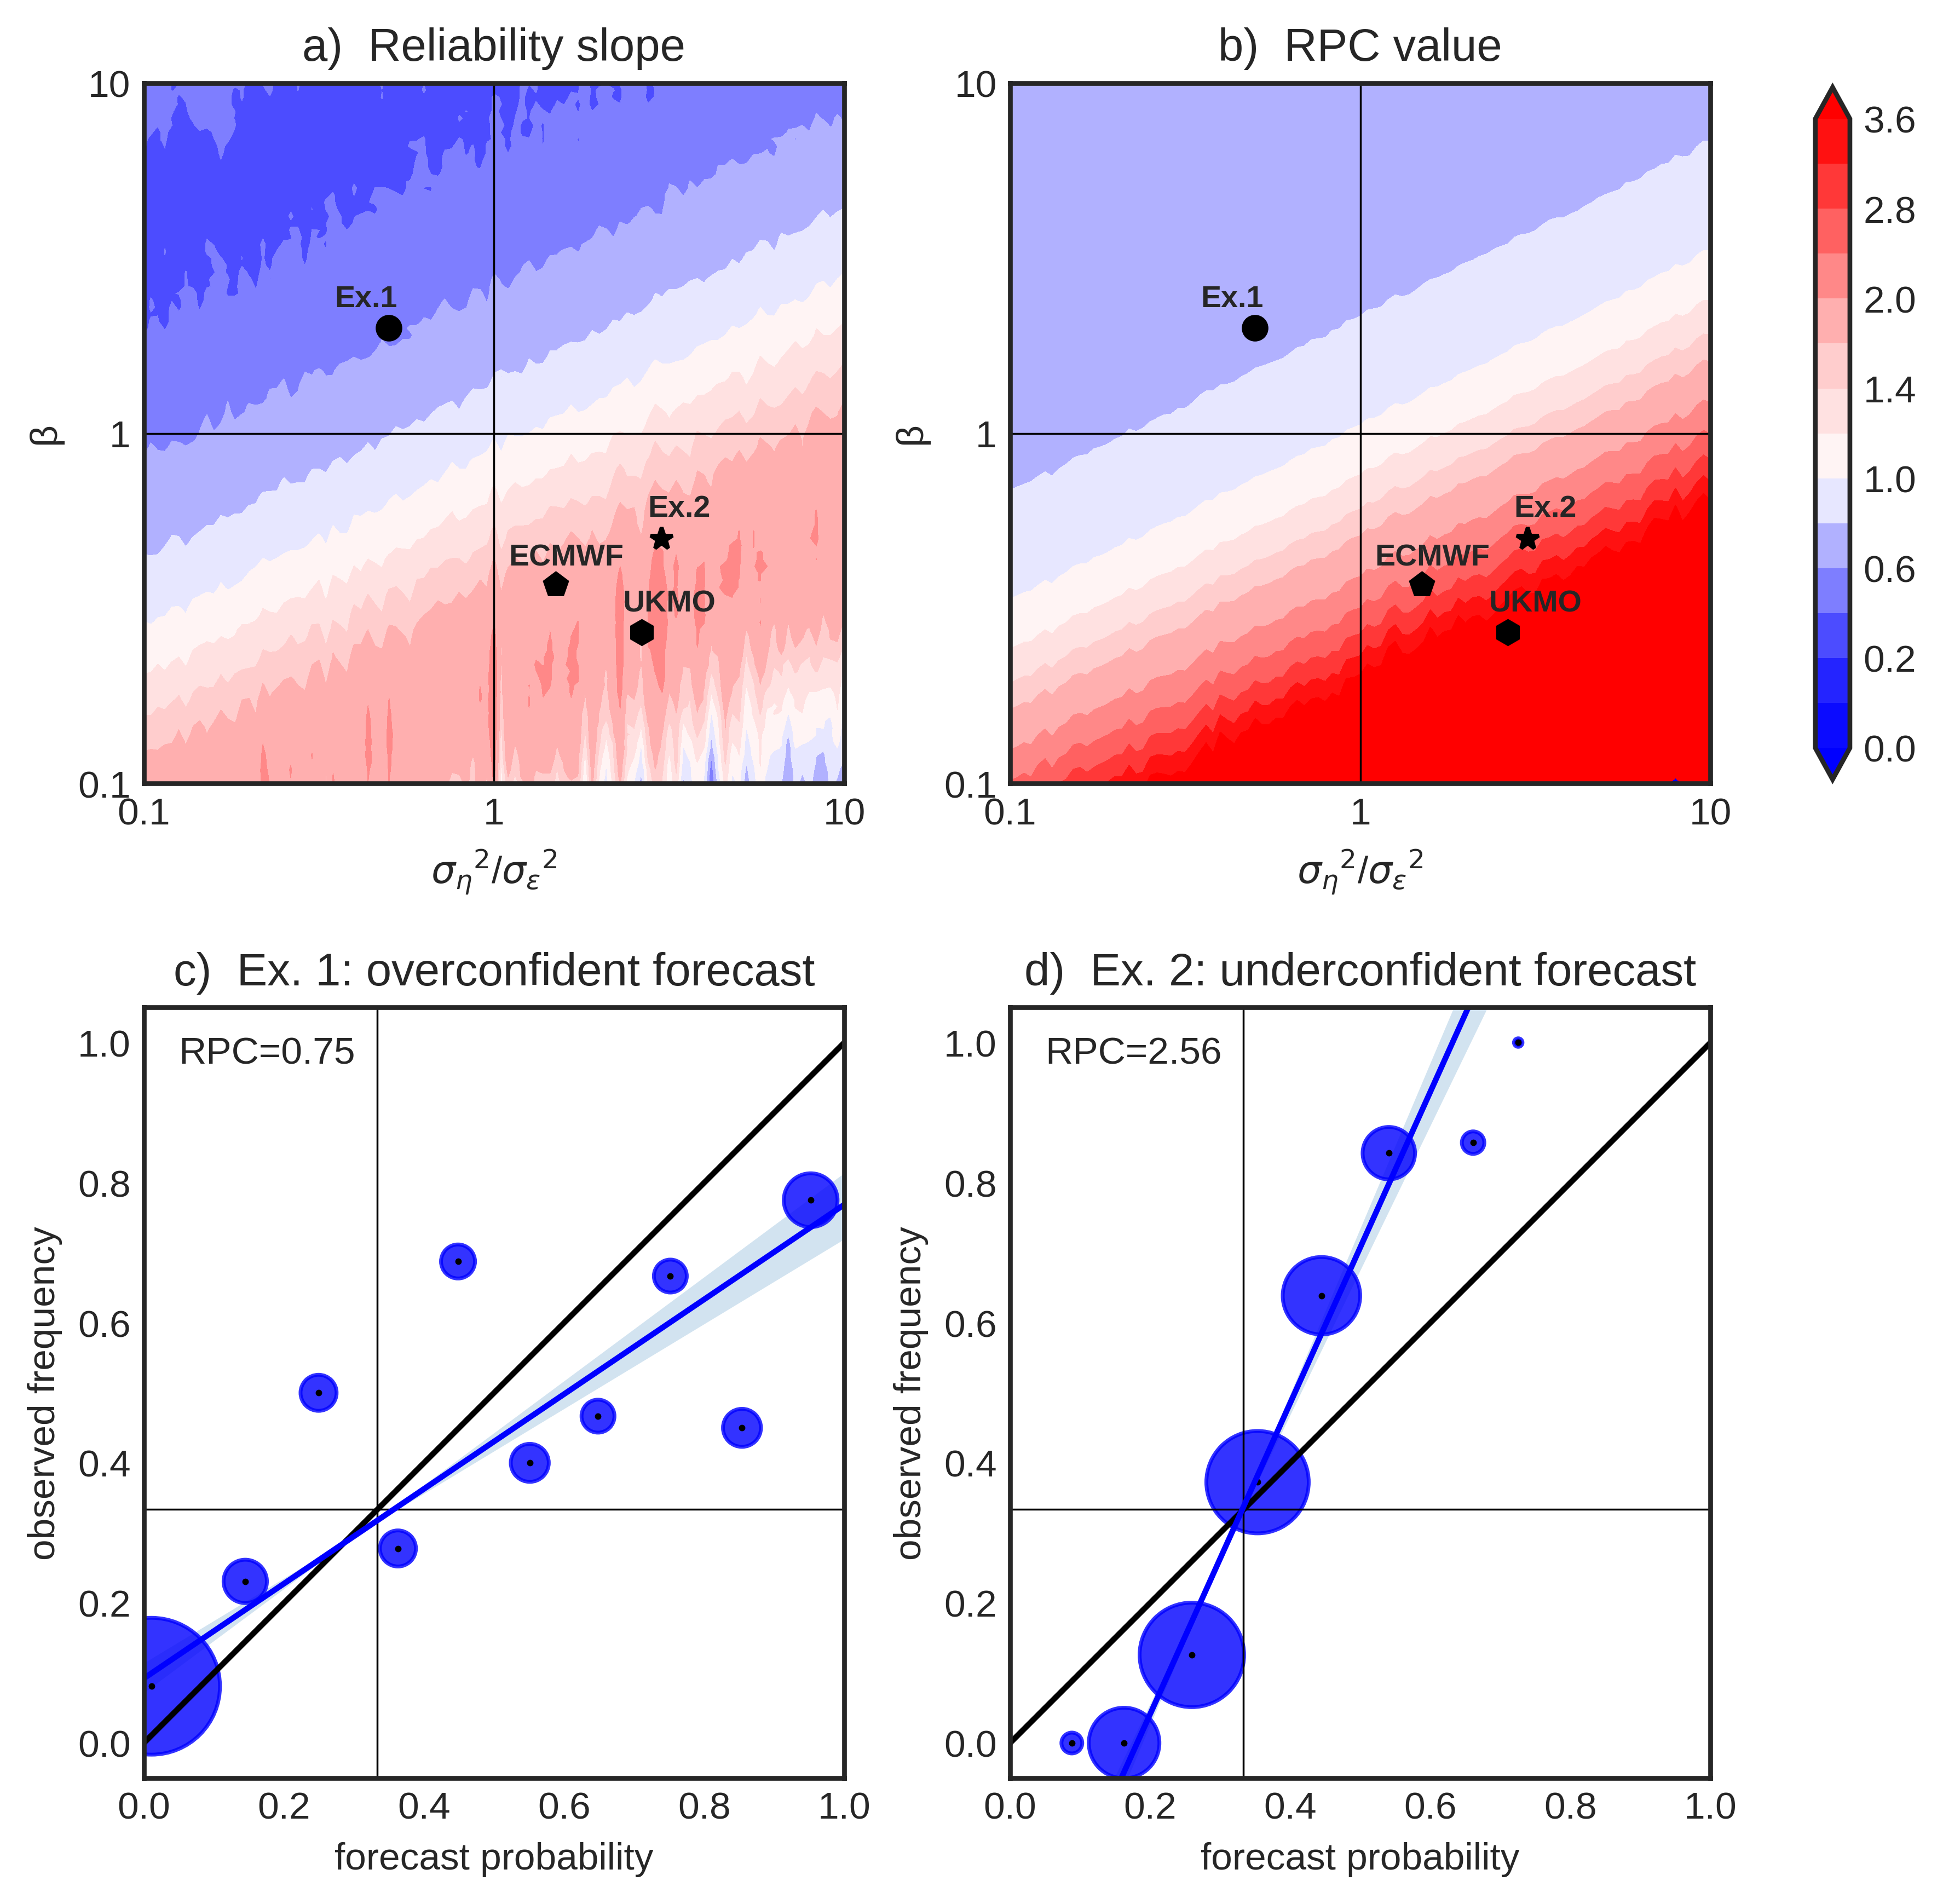

In [13]:
#idealised contour plot and RPC
fig, axs = plt.subplots(2,2, figsize=(7,7), dpi=500, constrained_layout=True)

beta=np.logspace(-1,1,101)
alpha=np.logspace(-1,1,101)

for i in range(2):
    axs[0,i].set_ylabel("β")
    axs[0,i].set_xlabel("$σ_{η}$$^2$/$σ_{ε}$$^2$")
    axs[0,i].plot(alpha, np.ones(101), color='black', linewidth=0.5)
    axs[0,i].plot(np.ones(101), beta, color='black', linewidth=0.5)
    axs[0,i].set_yscale('log')
    axs[0,i].set_xscale('log')
    
#examples
for i in range(2):
    axs[0,i].plot(alpha1, beta1,'go', c='black', marker=".", ms=12, label='Ex.1')
    axs[0,i].plot(alpha2, beta2,'go', c='black', marker="*", label='Ex.2')
    axs[0,i].annotate('Ex.1',(alpha1-0.15, beta1+0.3), fontsize=8, weight='bold')
    axs[0,i].annotate('Ex.2',(alpha2-0.25, beta2+0.08), fontsize=8, weight='bold')

#GloSea5
#alpha3=62.17/16.77
#beta3=0.23
alpha3 = (0.99/0.61)**2
beta3 = 0.27
for i in range(2):
    axs[0,i].plot(alpha3, beta3,'go', c='black', marker="h", label='GloSea5')
    axs[0,i].annotate('UKMO',(alpha3-0.3, beta3+0.04), fontsize=8, weight='bold')

#ECMWF
#alpha4=(4518.92/3776.80)**2
#beta4=0.3
alpha4 = (0.98/0.80)**2
beta4 = 0.37
for i in range(2):
    axs[0,i].plot(alpha4, beta4,'go', c='black', marker="p", label='ECMWF')
    axs[0,i].annotate('ECMWF',(alpha4-0.4, beta4+0.05), fontsize=8, weight='bold')
   
#RPC contour plot
axs[0,1].set_title("b)  RPC value", size=12)
RPC=np.loadtxt("RPC_contour_data_est.txt").reshape(101,101)
level=[0,0.1,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,2,2.4,2.8,3.2,3.6]
c=axs[0,1].contourf(alpha,beta, RPC, 20, levels=level, extend='both', cmap=shifted_cmap)

#idealised contour plot
axs[0,0].set_title("a)  Reliability slope", size=12)
dat_array=np.loadtxt("idealised_contour_data.txt").reshape(101,101)
cs=axs[0,0].contourf(alpha,beta, dat_array,  levels=level,cmap=shifted_cmap, extend='both')

cbar = plt.colorbar(cs, ax=axs[0,:],  location='right', shrink=0.8)


#reliability plots

for i in range(2):
    axs[1,i].plot(x,t,c='black',linewidth=0.5)
    axs[1,i].plot(t,yt,c='black', linewidth=0.5)
    axs[1,i].plot(x,y,c='black')
    axs[1,i].set_xlim([0, 1])
    axs[1,i].set_ylim([-0.05, 1.05])
    axs[1,i].set_xlabel('forecast probability')
    axs[1,i].set_ylabel('observed frequency')
#ex 1
axs[1,0].plot(x,q_reg*x+q_int, c='blue')
axs[1,0].fill_between(x,y1_uncu,y2_uncu,alpha=0.2)
axs[1,0].scatter(x_u, y_u, c='blue', s=size_u, alpha=0.8)
axs[1,0].scatter(x_u, y_u, c='black', s=0.5)

#ex 2
axs[1,1].plot(x,q_regl*x+q_intl, c='blue')
axs[1,1].fill_between(x, y1_uncl, y2_uncl, alpha=0.2)
axs[1,1].scatter(x_l, y_l, c='blue', s=size_l, alpha=0.8)
axs[1,1].scatter(x_l, y_l, c='black', s=0.5)

axs[1,0].set_title('c)  Ex. 1: overconfident forecast', size=12)
axs[1,1].set_title('d)  Ex. 2: underconfident forecast', size=12)

for i in range(2):
    for j in range(2):
        axs[0,j].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
        axs[0,j].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
        axs[i,j].set_aspect(1)
#lgn1 = axs[0,0].legend(loc='upper right', fontsize=8, framealpha=0.6, prop=dict(weight='bold'))
#lgn2 = axs[0,1].legend(loc='upper right', fontsize=8, facecolor='white', prop=dict(weight='bold'))
#lgn1.legendHandles[0]._legmarker.set_markersize(6)

axs[1,1].annotate('RPC=2.56',(0.05,0.97))
axs[1,0].annotate('RPC=0.75',(0.05,0.97))

plt.savefig('/network/home/s/strommen/Python/Projects/ReliabilityDiags/MollySummerProject/Figure1.png', bbox_inches='tight')
plt.show()

In [19]:
#estimating ECMWF parameters
from scipy.stats import pearsonr

def estimate(era, hindcast):
  #print era
  #print hindcast
  ensmean = hindcast.mean(axis=0)
  ensmean_mean = ensmean.mean()
  ensmean_var = ensmean.var()
  era_mean = era.mean()
  era_var = era.var()
  cov = np.cov(era, ensmean)[0][1]
  #cor = corr(era, ensmean)
  member_vars = []
  member_covs = []
  member_cors = []
  for k in range(51):
    mem = hindcast[k,:]
    member_vars.append(mem.var())
    for m in range(51):
      if m == k:
        pass
      else:
        member_covs.append(np.cov(mem, hindcast[m,:])[0][1])
        member_cors.append(pearsonr(mem, hindcast[m,:])[0])

  member_cov = np.array(member_covs).mean()
  member_var = np.array(member_vars).mean()
  member_cors = np.array(member_cors)
  beta = (ensmean_var - (1./51)*member_var)/(cov)
  beta2 = member_cov/cov

  sigma_s = np.sqrt(abs(cov/beta))
  sigma_eps = np.sqrt(abs(era_var-sigma_s**2))
  sigma_eta = np.sqrt(abs(member_var))
  mu_era = era_mean
  mu_mod = ensmean_mean
  print(("beta = %.2f" % beta))
  print(("beta2 = %.2f" % beta2))
  print(("sigma_s = %.2f" % sigma_s))
  print(("sigma_eps = %.2f" % sigma_eps))
  print(("sigma_eta = %.2f" % sigma_eta))
  print(("mu_obs = %.2f" % mu_era))
  print(("mu_mod = %.2f" % mu_mod))
  return beta, sigma_s, sigma_eps, sigma_eta, mu_era, mu_mod

import numpy as np

x_yrs=np.arange(31)+78

#model data
PCs_data_full = np.loadtxt("Downloads/PCs_1902-2010_daily_jet_adjusted.txt")
PCs_full=PCs_data_full.reshape(51, 109)
#selecting relevant years of full dataset:
ensemble=PCs_full[:,x_yrs]

#observed data
tas_cube_o_full = np.loadtxt('Downloads/ERA20C_PCs_1902-2010_daily_jet_adjusted.txt')
obs = tas_cube_o_full[x_yrs]

estimate(obs, ensemble)



OSError: Downloads/PCs_1902-2010_daily_jet_adjusted.txt not found.

In [1]:


#reliability plots

for i in range(2):
    axs[1,i].plot(x,t,c='black',linewidth=0.5)
    axs[1,i].plot(t,yt,c='black', linewidth=0.5)
    axs[1,i].plot(x,y,c='black')
    axs[1,i].set_xlim([0, 1])
    axs[1,i].set_ylim([-0.05, 1.05])
    axs[1,i].set_xlabel('forecast probability')
    axs[1,i].set_ylabel('observed frequency')
#ex 1
axs[1,0].plot(x,q_reg*x+q_int, c='blue')
axs[1,0].fill_between(x,y1_uncu,y2_uncu,alpha=0.2)
axs[1,0].scatter(x_u, y_u, c='blue', s=size_u, alpha=0.8)
axs[1,0].scatter(x_u, y_u, c='black', s=0.5)

#ex 2
axs[1,1].plot(x,q_regl*x+q_intl, c='blue')
axs[1,1].fill_between(x, y1_uncl, y2_uncl, alpha=0.2)
axs[1,1].scatter(x_l, y_l, c='blue', s=size_l, alpha=0.8)
axs[1,1].scatter(x_l, y_l, c='black', s=0.5)

axs[1,0].set_title('c)  Example 1: overconfident model', size=10)
axs[1,1].set_title('d)  Example 2: underconfident model', size=10)

for i in range(2):
    for j in range(2):
        axs[0,j].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
        axs[0,j].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
        axs[i,j].set_aspect(1)
axs[0,0].legend(loc='upper right', fontsize='x-small', framealpha=0.6)
axs[0,1].legend(loc='upper right', fontsize='x-small', facecolor='white')

axs[1,1].annotate('RPC=2.56',(0.05,0.97))
axs[1,0].annotate('RPC=0.75',(0.05,0.97))

plt.savefig('Documents/4_panel_idealised', bbox_inches='tight')
plt.show()

hello
